In [1]:
%run data.py

### Read data from NYC Open Data

In [2]:
results_df = fetch_nycOpenData(nyc_licenseApp, 100, 500000)
results_df.head(10)

,application_id,license_number,license_type,application_or_renewal,business_name,status,start_date,end_date,license_category,application_category,...,contact_phone,longitude,latitude,unit_type,unit,description,street_2,temp_op_letter_issued,temp_op_letter_expiration,active_vehicles
0,1066-2017-RHIC,1294131-DCA,Business,Renewal,PEYKO TZENOV,Issued,2017-01-09T00:00:00.000,2017-01-10T00:00:00.000,Home Improvement Contractor,Special,...,9178047161,-73.877091,40.876214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1164-2019-RDPD,1472251-DCA,Business,Renewal,AMERICAN EAST PHARMACY INC.,Issued,2019-01-09T00:00:00.000,2019-01-10T00:00:00.000,Dealer In Products,Basic,...,2129251900,-73.996169,40.7141181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33701-2016-RELE,2025971-DCA,Business,Renewal,LUCAS ELECTRONICS INC,Issued,2016-12-31T00:00:00.000,2017-01-10T00:00:00.000,Electronics Store,Basic,...,347-987-3235,-73.954098,40.7298694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34278-2018-RELE,2047043-DCA,Business,Renewal,ELITE WIRELESS GROUP NY LLC,Issued,2018-12-31T00:00:00.000,2019-01-08T00:00:00.000,Electronics Store,Basic,...,718-484-7746,-73.949327,40.6508262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3891-2019-ALAU,2085269-DCA,Business,Application,"A-LIN LAUNDROMAT, INC.",Issued,2019-04-07T00:00:00.000,2019-05-02T00:00:00.000,Laundries,Basic,...,NaN,-74.015602,40.6435489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12418-2017-AELE,2057790-DCA,Business,Application,RIDGE WIRELESS CORP,Issued,2017-08-31T00:00:00.000,2017-09-02T00:00:00.000,Electronics Store,Basic,...,NaN,-74.031289,40.6156532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,949-2017-RHIC,1338463-DCA,Business,Renewal,"TAORMINA, MICHAEL",Issued,2017-01-06T00:00:00.000,2017-01-07T00:00:00.000,Home Improvement Contractor,Special,...,6312362914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,348-2017-RDEB,1325842-DCA,Business,Renewal,CREDIGY RECEIVABLES INC.,Issued,2017-01-09T00:00:00.000,2017-01-11T00:00:00.000,Debt Collection Agency,Basic,...,702-543-3036,NaN,NaN,UNIT,303,NaN,NaN,NaN,NaN,NaN
8,7887-2016-RPDD,1387189-DCA,Individual,Renewal,SOULEYMANE TOURE,Issued,2016-05-06T00:00:00.000,2016-05-06T00:00:00.000,Pedicab Driver,Basic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,30775-2018-RHIC,2026096-DCA,Business,Renewal,AMERICAN STANDARD INTERIORS CORP,Denied,2018-12-05T00:00:00.000,2019-01-07T00:00:00.000,Home Improvement Contractor,Special,...,NaN,-73.929278,40.7599091,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = pandas_to_spark(results_df)

In [4]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import month, year

# group table by month.
df = df.withColumn("date", to_timestamp("start_date", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
df = df.filter(df["date"] >= to_timestamp(f.lit('2019-09-01 00:00:00')).cast('timestamp'))
data = df.groupBy(month("date").alias("month")).count()

data = data.withColumn("month_name", 
                                            f.when(f.col('month') == 1, "2020-01")\
                                            .when(f.col('month') == 2, "2020-02")\
                                            .when(f.col('month') == 3, "2020-03")\
                                            .when(f.col('month') == 4, "2020-04")\
                                            .when(f.col('month') == 9, "2019-09")\
                                            .when(f.col('month') == 10, "2019-10")\
                                            .when(f.col('month') == 11, "2019-11")\
                                            .when(f.col('month') == 12, "2019-12"))

data = data.orderBy("month_name")
data = data.select(data["month_name"], data["count"].alias("licenseApplication"))

### Calculate the average license applications before March 2020. 

In [8]:
avg_data = data.filter(data["month_name"] != "2020-03")
avg_data = avg_data.filter(data["month_name"] != "2020-04")
avg_data.show()

+----------+------------------+
|month_name|licenseApplication|
+----------+------------------+
|   2019-09|              3222|
|   2019-10|              3501|
|   2019-11|              4125|
|   2019-12|              3277|
|   2020-01|              3314|
|   2020-02|              2748|
+----------+------------------+



In [9]:
avg_data.createOrReplaceTempView("avg_data")
avg_num = spark.sql("SELECT avg(licenseApplication) as avg_num FROM avg_data")
avg_num = avg_num.rdd.map(list)
avg_number = avg_num.take(1)[0][0]
print("Average license applications before March 2020 is: ", avg_number)

Average license applications before March 2020 is:  3364.5


### Calculate the falling rate.

In [13]:
data.createOrReplaceTempView("latest_data")
latest_number = spark.sql("SELECT licenseApplication FROM latest_data WHERE month_name = \
                                     (SELECT max(month_name) FROM  latest_data)")

latest_number = latest_number.rdd.map(list)
latest_number = latest_number.take(1)[0][0]
falling_rate = (avg_number - latest_number) / avg_number
print("Falling rate is: ", falling_rate)

falling_rate = falling_rate * 100

Falling rate is:  0.8698172090949621


In [14]:
falling_rate_str = "↓" + str('%.2f' % falling_rate) + "%"

In [5]:
import matplotlib.pyplot as plt
plt.close('all')

d = data.toPandas()
d.head(10)

,month_name,licenseApplication
0,2019-09,3222
1,2019-10,3501
2,2019-11,4125
3,2019-12,3277
4,2020-01,3314
5,2020-02,2748
6,2020-03,1844
7,2020-04,438


### Plot.

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

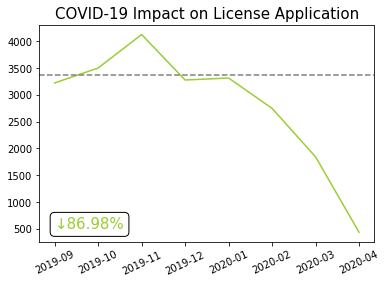

In [15]:
#license application
plt.plot("month_name", "licenseApplication", data = d, color = "yellowgreen")

#average job applications before March 2020
plt.axhline(y = avg_number,ls = "dashed",color = "grey") 

#title
plt.title("COVID-19 Impact on License Application",fontsize = 15)

#annotaion: falling rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 500, falling_rate_str, size = 15, color = "yellowgreen", bbox=bbox_props)

plt.xticks( rotation=25)